In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from numpy import argmax
from scipy import constants
import random

import os
import sys
import re
import pdb
import glob

import suftware

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Lambda, Concatenate
from keras.optimizers import Adam
from keras import metrics
from keras import regularizers
from keras import callbacks
import keras.backend as K

import tensorflow as tf

from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline
plt.ion()

Using TensorFlow backend.


In [2]:
# Load the energy matrices from Kinney et al. 2010
crp_df = pd.read_csv('../data/energy_matrices/crp_tau_final_all.26.txt', sep = "\t", usecols = range(1,5))
rnap_df = pd.read_csv('../data/energy_matrices/rnap_tau_final_all.41.txt', sep = "\t", usecols = range(1,5))

# Convert the dataframe to numpy array for downstream processing
crp_array = pd.DataFrame.to_numpy(crp_df)
rnap_array = pd.DataFrame.to_numpy(rnap_df)

In [3]:
def mutate_sequence(con_seq, mut_rate):
    bases = ["A","C","G","T"]
    new_seq = list(con_seq)
    to_mutate = np.random.random(size = len(con_seq)) < mut_rate
    for i in range(0,len(to_mutate)):
        if to_mutate[i]:
            new_seq[i] = random.choice([b for b in bases if b not in new_seq[i]])
    return ''.join(new_seq)

# Fit a label encoder and a onehot encoder
bases = ["A","C","G","T"]
label_encoder = LabelEncoder()
label_encoder.fit(bases)
tmp = label_encoder.transform(bases)
tmp = tmp.reshape(len(tmp), 1)
onehot_encoder = OneHotEncoder(sparse = False)
onehot_encoder.fit(tmp)

# Encode sequence into onehot
def onehot_sequence(sequence, lab_encoder = label_encoder, one_encoder = onehot_encoder):
    """Sequence as a string"""
    tmp = lab_encoder.transform(list(sequence))
    tmp = tmp.reshape(len(tmp),1)
    tmp = one_encoder.transform(tmp)
    return tmp

# Calculate energy
def get_energy(seq_onehot, matrix_array):
    return np.sum(matrix_array * seq_onehot)

# Calculate boltzmann weight
def get_transcription(energy,mu=2.7):
    tau_max = 1.00
    return tau_max*(np.exp(-(energy-mu))/(1+np.exp(-(energy-mu))))

In [4]:
# Set up parameters
gaps = 7 # Length of gaps between CRP and RNAP binding sites
c_r = 5.94e-3 # Concentration of RNAP; Empirically determined
c_c = 10 ** -1.2 # Concentration of active CRP
e_i = -3.26 # Energy of interaction
t_bg = 0.01 # Background noise
consensus_sequence = "AATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG"
crp_wt_energy = 6.9 # From Kinney et al. 2010
rnap_wt_energy = 8.3 # From Kinney et al. 2010

In [5]:
# Create a single energy matrix
energy_array = np.concatenate((crp_array, np.zeros([gaps,4]), rnap_array))

# Obtain positional information from the parameters given
crp_start = 1
crp_end = crp_start + len(crp_array)
gap_start = crp_end
gap_end = gap_start + gaps
rnap_start = gap_end
rnap_end = rnap_start + len(rnap_array)

In [6]:
#input_data_crp = pd.read_csv('crp-wt/data.txt',delim_whitespace=True)
input_data_full_wt = pd.read_csv('../data/full-wt/data.txt',delim_whitespace=True)

In [7]:
sequences = []
bin_number = []

for _ in range(len(input_data_full_wt)):
    sequences.append(input_data_full_wt['seq'][_])
    bin_number.append(argmax(input_data_full_wt.iloc[_,1:len(input_data_full_wt.columns)].values))

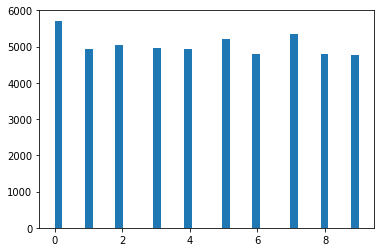

In [8]:
plt.hist(bin_number,bins=40)
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(sequences, bin_number, test_size=0.2)

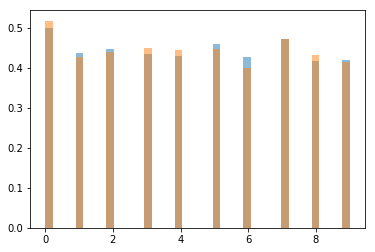

In [10]:
plt.hist(y_train,bins=40,alpha=0.5,density=True)
plt.hist(y_test,bins=40,alpha=0.5,density=True)
plt.show()

In [11]:
#len(X_train[0][1:27]+X_train[0][33:74])

In [12]:
######
## Define custom function for keras
######

def log_poisson_loss(y_true, y_pred):
    return tf.nn.log_poisson_loss(y_true,y_pred)

def poisson_loss(y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    return K.mean(y_pred - y_true * math_ops.log(y_pred + K.epsilon()), axis=-1)


In [13]:
# convert the crp part of the sequence to one hot encoding
input_seqs_ohe = []
for _ in range(len(X_train)):
    #input_seqs_ohe.append(onehot_sequence(X_train[_][1:27]+X_train[_][33:74]))
    input_seqs_ohe.append(onehot_sequence(X_train[_][1:27]+X_train[_][34:75]))
    
test_seqs_ohe = []    
for _ in range(len(X_test)):
    #test_seqs_ohe.append(onehot_sequence(X_test[_][1:27]+X_test[_][33:74]))
    test_seqs_ohe.append(onehot_sequence(X_test[_][1:27]+X_test[_][34:75]))

In [14]:
print(np.shape(input_seqs_ohe))
print(np.shape(test_seqs_ohe))

(40414, 67, 4)
(10104, 67, 4)


In [15]:
# one-hot encoding for y-labels

number_bins = 10

def int_to_onehot(n, n_classes):
    v = [0] * n_classes
    v[n] = 1
    return v

y_train_ohe = []
y_test_ohe = []

for _ in range(len(y_train)):
    y_train_ohe.append(int_to_onehot(y_train[_], number_bins))
    
for _ in range(len(y_test)):
    y_test_ohe.append(int_to_onehot(y_test[_], number_bins))    

In [16]:
np.shape(y_train_ohe[1])[0]

10

In [17]:
number_input_layer_nodes = len(input_seqs_ohe[0])*4    
inputTensor = Input((number_input_layer_nodes,),name='Sequence')

In [18]:
#import tensorflow as tf
from keras.layers import multiply

class CustomConnected(Dense):

    def __init__(self,units,connections, output_dim,**kwargs):
        
        self.output_dim = output_dim
        #this is matrix of connections. I.e., this should be [0,0,trainable,trainable]
        self.connections = connections                        
        #initalize the original Dense with all the usual arguments   
        super(CustomConnected,self).__init__(units,**kwargs)  


    def call(self, inputs):
        #print(self.connections)
        
        kernel_times_connections = multiply([self.kernel, self.connections])
        #output = K.dot(inputs, self.kernel * self.connections)
        
        # for implementing custom constraint, print out kernel. Set last two elements equal to each other.
        output = K.dot(inputs,kernel_times_connections)

        #print('outputs: ',output)
        #print('inputs: ',inputs)
        #print('kernel',self.kernel)
        
        if self.use_bias:
            output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    

In [19]:
#from tensorflow.keras import layers
from keras import layers
import tensorflow as tf


class CustomSoftmax(layers.Layer):

    def __init__(self, units=4, input_dim=2,output_dim=4):
        self.output_dim = output_dim
        super(CustomSoftmax, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal',
                                 name='weights',
                                 trainable=False)
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros',
                                 name='bias',
                                 trainable=True)

    def call(self, inputs):
        
        #return K.dot(inputs, self.w) + self.b
        #return K.dot(self.w,inputs) + self.b
        #return tf.matmul(inputs, self.w) + self.b
        output = tf.nn.softmax(tf.matmul(inputs, self.w) + self.b) 
        print('output:',output)
        return output

In [20]:
class CustomSoftmax2(layers.Layer):

    def __init__(self, units=4, input_dim=2,output_dim=4):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.units = units
        super(CustomSoftmax2, self).__init__()
        
    
    def build(self, input_shape): 
        
        self.w = self.add_weight(shape=(self.input_dim, self.units),
                                 initializer='random_normal',
                                 name='weights',
                                 trainable=False)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 name='bias',
                                 trainable=True)
        
        super(CustomSoftmax2, self).build(input_shape)    

    def call(self, inputs):
        
        #return K.dot(inputs, self.w) + self.b
        #return K.dot(self.w,inputs) + self.b
        #return tf.matmul(inputs, self.w) + self.b
        output = tf.nn.softmax(tf.matmul(inputs, self.w) + self.b) 
        print('output:',output)
        return output
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

In [21]:
# define two groups which represent binding sites for the two proteins crp and rnap

group1 = Lambda(lambda x: x[:,0:104], output_shape=((104,)))(inputTensor)
group2 = Lambda(lambda x: x[:,104:268], output_shape=((164,)))(inputTensor)


# From input to first hidden layer. The groups are connected to two nodes
# node group1 represents energy of crp and group2 represents rnap energy.

# rename group1 to crp pwm

group1 = Dense(1,use_bias=False,name='CRP_pwm')(group1)
group2 = Dense(1,use_bias=False,name='RNAP_pwm')(group2)
#group2 = Dense(1,use_bias=False,name='RNAP_pwm',kernel_initializer='RandomNormal',W_constraint=nonneg())(group2)

# the groups from the previous layer have to be concatenated so
concatenateLayer = Concatenate()([group1,group2])

# gammaInput = Input(shape=(1,),name='gamma_Input')   # i.e. weights going into softmax: [0,0,0,1]
# concatenateLayer_with_gamma = Concatenate()([group1,group2,gammaInput])


# softmax layer needs to have multiple inputs

# try custom connections in the trainable softmax
#softmaxLayer = Dense(4,activation='softmax', trainable=True, use_bias=True,name='softmax_layer')(concatenateLayer)
#softmaxLayer = CustomSoftmax(4,2)(concatenateLayer)
softmaxLayer = CustomSoftmax2(4,input_dim= 2,output_dim=4)(concatenateLayer)
#softmaxLayer = Dense(4,activation='softmax', trainable=False, use_bias=True,name='softmax_layer')(concatenateLayer_with_gamma)

# tauTensor = CustomConnected(1,tf.constant([0.0,0.0,1.0,1.0]),1,use_bias=False,name='custom_tau_layer')(softmaxLayer)
# outputTensor = Dense(np.shape(y_train_ohe[1])[0],activation='softmax', trainable=True, use_bias=False,name='softmax_layer_bins')(tauTensor)

tauTensor = CustomConnected(1,tf.constant([0.0,0.0,1.0,1.0]),1,use_bias=False,name='custom_tau_layer')(softmaxLayer)
intermediateTensor = Dense(5,activation='softmax', trainable=True, use_bias=False,name='softmax_layer_intermediate')(tauTensor)
outputTensor = Dense(np.shape(y_train_ohe[1])[0],activation='softmax', trainable=True, use_bias=False,name='softmax_layer_bins')(intermediateTensor)


#create the model:
model = Model(inputTensor,outputTensor)
# model = Model(inputs=[inputTensor, gammaInput], outputs=outputTensor)



output: Tensor("custom_softmax2_1/Softmax:0", shape=(?, 4), dtype=float32)


In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Sequence (InputLayer)           (None, 268)          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 104)          0           Sequence[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 164)          0           Sequence[0][0]                   
__________________________________________________________________________________________________
CRP_pwm (Dense)                 (None, 1)            104         lambda_1[0][0]                   
__________________________________________________________________________________________________
RNAP_pwm (

In [23]:
model.layers

In [24]:
model.layers[7].get_weights()

[array([[1.0283334 ],
        [0.99609876],
        [0.22673178],
        [0.06362128]], dtype=float32)]

### Set initial weights for last layer...
...so that only the last two states (S3 and S4 in write-up) contribute to transcription

In [25]:
tau_layer_weights = model.layers[7].get_weights()[0].copy()
tau_layer_weights.shape

(4, 1)

In [26]:
tau_layer_initial_weights = np.array([0,0,1,1])
tau_layer_initial_weights = tau_layer_initial_weights.reshape(4,1)
model.layers[7].set_weights([tau_layer_initial_weights])
model.layers[7].get_weights()[0]

array([[0.],
       [0.],
       [1.],
       [1.]], dtype=float32)

### The following show non-trainable and trainable weights in the softmax layer

In [27]:
print(model.layers[6].get_weights()[0])
print(model.layers[6].get_weights()[1])

[0. 0. 0. 0.]
[[-0.01977255 -0.05629922 -0.03046174  0.03169172]
 [-0.01356356  0.00277144  0.07141899  0.04618514]]


### Set softmax layer weights manually, will be kept frozen during training
Note that the bias weights here may be interpreted as gamma

In [28]:
# the following are the input weights to the softmax array.
# the first two arrays indicate 4 weights each coming out of the e_c and 
# e_r nodes. The last node indicates the gamma input, connecting only to
# microstate 4.

softmax_weights = np.array([[0,1,0,1],[0,0,1,1]])
softmax_biases = np.array([0,0,0,1])

# keras' set_weights expects weights and bias in a list
softmax_weights = [softmax_biases,softmax_weights]

# without bias
# softmax_weights = [softmax_weights]

# set weights
model.layers[6].set_weights(softmax_weights)
# see set weights
model.layers[6].get_weights()

[array([0., 0., 0., 1.], dtype=float32), array([[0., 1., 0., 1.],
        [0., 0., 1., 1.]], dtype=float32)]

## Compile model

In [29]:
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.0005), metrics=['mean_absolute_error'])
#model.compile(loss='mean_squared_error',optimizer=sgd, metrics=['mean_absolute_error'])

In [30]:
np.array(X_train).shape[0]

40414

## prepare intermediate gamma input

In [31]:
gamma_input_list = []
for _ in range(np.array(X_train).shape[0]):
    # the following input gets multiplied by weights [0,0,0,1], 
    # connecting only the 4th microstate
    #gamma_input_list.append(np.array([1.0]))
    gamma_input_list.append(np.array([-3.26]))
    #gamma_input_list.append(np.array([3.26]))
    

In [32]:
gamma_input_list = np.array(gamma_input_list)
gamma_input_list.shape

(40414, 1)

In [33]:
input_seqs_ohe = np.array(input_seqs_ohe)
input_sequences_tensor = input_seqs_ohe.reshape(-1,len(input_seqs_ohe[0])*4)

test_seqs_ohe = np.array(test_seqs_ohe)
test_input_sequences_tensor = test_seqs_ohe.reshape(-1,len(test_seqs_ohe[0])*4)

labels = np.array(y_train_ohe)
test_labels = np.array(y_test_ohe)

In [34]:
######
## Define custom function for keras
######

def log_poisson_loss(y_true, y_pred):
    return tf.nn.log_poisson_loss(y_true,y_pred)

def poisson_loss(y_true, y_pred):
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = math_ops.cast(y_true, y_pred.dtype)
    return K.mean(y_pred - y_true * math_ops.log(y_pred + K.epsilon()), axis=-1)


In [35]:
#model.compile(loss=log_poisson_loss,optimizer=Adam(lr=0.00001), metrics=['categorical_accuracy'])
model.compile(loss=log_poisson_loss,optimizer=Adam(lr=0.0005), metrics=['categorical_accuracy'])

In [36]:
# history = model.fit([input_sequences_tensor,gamma_input_list], labels, 
#                     validation_split=0.1, epochs=100,verbose=1,callbacks=[esCallBack,tbCallBack])  

history = model.fit(input_sequences_tensor, labels, validation_split=0.2, epochs=100,verbose=1)

Train on 32331 samples, validate on 8083 samples
Epoch 1/100
32331/32331 [==============================] - 1s 35us/step - loss: 1.0952 - categorical_accuracy: 0.1124 - val_loss: 1.0952 - val_categorical_accuracy: 0.1120
Epoch 2/100
32331/32331 [==============================] - 1s 33us/step - loss: 1.0952 - categorical_accuracy: 0.1124 - val_loss: 1.0952 - val_categorical_accuracy: 0.1120
Epoch 3/100
32331/32331 [==============================] - 1s 35us/step - loss: 1.0952 - categorical_accuracy: 0.1124 - val_loss: 1.0952 - val_categorical_accuracy: 0.1120
Epoch 4/100
32331/32331 [==============================] - 1s 35us/step - loss: 1.0952 - categorical_accuracy: 0.1124 - val_loss: 1.0952 - val_categorical_accuracy: 0.1120
Epoch 5/100
32331/32331 [==============================] - 1s 31us/step - loss: 1.0952 - categorical_accuracy: 0.1124 - val_loss: 1.0952 - val_categorical_accuracy: 0.1120
Epoch 6/100
32331/32331 [==============================] - 1s 32us/step - loss: 1.0952 - ca

32331/32331 [==============================] - 1s 28us/step - loss: 1.0905 - categorical_accuracy: 0.2912 - val_loss: 1.0907 - val_categorical_accuracy: 0.2853
Epoch 49/100
32331/32331 [==============================] - 1s 36us/step - loss: 1.0905 - categorical_accuracy: 0.2926 - val_loss: 1.0907 - val_categorical_accuracy: 0.2818
Epoch 50/100
32331/32331 [==============================] - 1s 30us/step - loss: 1.0905 - categorical_accuracy: 0.2925 - val_loss: 1.0907 - val_categorical_accuracy: 0.2812
Epoch 51/100
32331/32331 [==============================] - 1s 29us/step - loss: 1.0905 - categorical_accuracy: 0.2941 - val_loss: 1.0907 - val_categorical_accuracy: 0.2858
Epoch 52/100
32331/32331 [==============================] - 1s 29us/step - loss: 1.0905 - categorical_accuracy: 0.2927 - val_loss: 1.0907 - val_categorical_accuracy: 0.2849
Epoch 53/100
32331/32331 [==============================] - 1s 31us/step - loss: 1.0905 - categorical_accuracy: 0.2930 - val_loss: 1.0906 - val_cate

32331/32331 [==============================] - 1s 40us/step - loss: 1.0902 - categorical_accuracy: 0.3008 - val_loss: 1.0905 - val_categorical_accuracy: 0.2888
Epoch 96/100
32331/32331 [==============================] - 1s 40us/step - loss: 1.0902 - categorical_accuracy: 0.3015 - val_loss: 1.0905 - val_categorical_accuracy: 0.2875
Epoch 97/100
32331/32331 [==============================] - 1s 40us/step - loss: 1.0902 - categorical_accuracy: 0.3015 - val_loss: 1.0905 - val_categorical_accuracy: 0.2803
Epoch 98/100
32331/32331 [==============================] - 1s 37us/step - loss: 1.0902 - categorical_accuracy: 0.3014 - val_loss: 1.0905 - val_categorical_accuracy: 0.2885
Epoch 99/100
32331/32331 [==============================] - 1s 35us/step - loss: 1.0902 - categorical_accuracy: 0.3011 - val_loss: 1.0905 - val_categorical_accuracy: 0.2853
Epoch 100/100
32331/32331 [==============================] - 1s 35us/step - loss: 1.0902 - categorical_accuracy: 0.3016 - val_loss: 1.0905 - val_cat

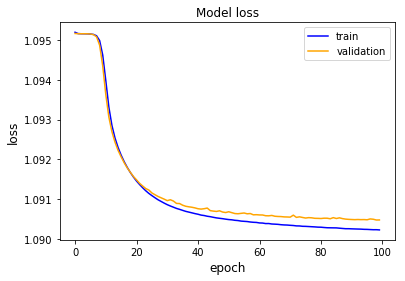

In [37]:
# plot losses

plt.figure()
plt.plot(history.history['loss'],color='blue')
plt.plot(history.history['val_loss'],color='orange')
plt.title('Model loss',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'validation'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

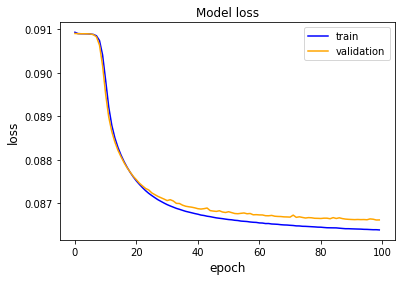

In [38]:
# plot losses

plt.figure()
plt.plot(np.log(history.history['loss']),color='blue')
plt.plot(np.log(history.history['val_loss']),color='orange')
plt.title('Model loss',fontsize=12)
plt.ylabel('loss',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['train', 'validation'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

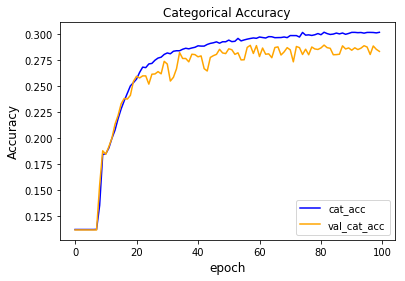

In [39]:
plt.figure()
plt.plot(history.history['categorical_accuracy'],color='blue')
plt.plot(history.history['val_categorical_accuracy'],color='orange')
plt.title('Categorical Accuracy',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('epoch',fontsize=12)
plt.legend(['cat_acc', 'val_cat_acc'])
#plt.savefig('Write_up/model_loss.png')
plt.show()

In [40]:
# predictions_on_test = model.predict(test_input_sequences_tensor)
predictions_on_test = model.predict(test_input_sequences_tensor)

In [41]:
model.evaluate(test_input_sequences_tensor,test_labels)

10104/10104 [==============================] - 0s 15us/step


[1.0903581212837359, 0.297307996809341]

### First hidden layer weights (PWMs)

Need to input sequence corresponding to CRPs binding site. i.e. fixed the shape of test_input_sequences_tensor

In [42]:
crp_weights = model.layers[3].get_weights()[0].copy()
rnap_weights = model.layers[4].get_weights()[0].copy()

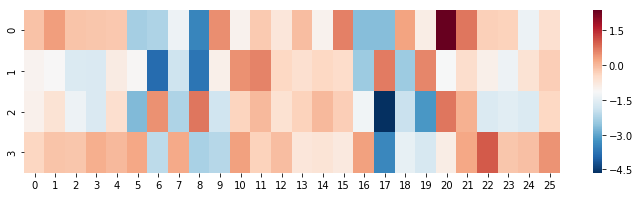

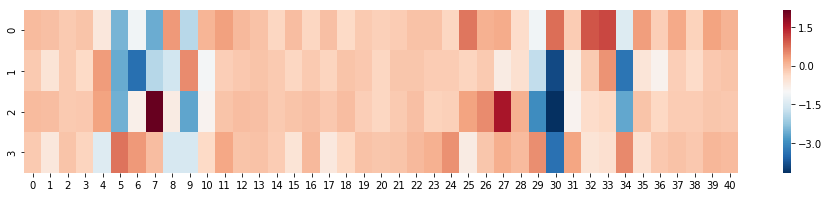

In [43]:
crp_weights = crp_weights.reshape(26,4)
rnap_weights = rnap_weights.reshape(41,4)


plt.figure(figsize=(12,3))
sns.heatmap(crp_weights.T,cmap='RdBu_r')
plt.show()
plt.figure(figsize=(16,3))
sns.heatmap(rnap_weights.T,cmap='RdBu_r')
#sns.heatmap(rnap_weights.T,cmap='RdBu_r')
plt.show()

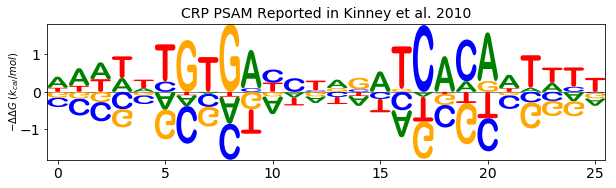

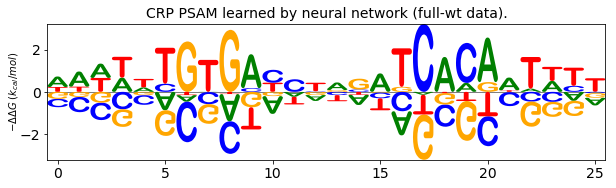

In [44]:
import logomaker
crp_logo_df = pd.DataFrame(crp_weights,columns=['A','C','G','T'])

crp_df.columns = ['A','C','G','T']
logomaker.Logo(-crp_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.tick_params(labelsize=14)
plt.title('CRP PSAM Reported in Kinney et al. 2010',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{cal}/mol$)", labelpad=-1)
logomaker.Logo(crp_logo_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.title('CRP PSAM learned by neural network (full-wt data).',fontsize=14)
plt.tick_params(labelsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{cal}/mol$)", labelpad=-1)

plt.show()
#logomaker.Logo(rnap_logo_df,center_values=True, font_name='Arial Rounded MT Bold')

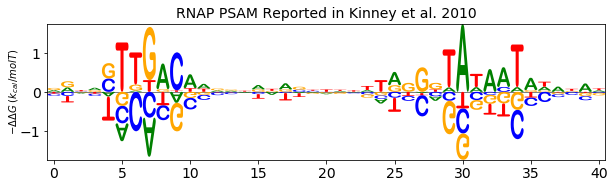

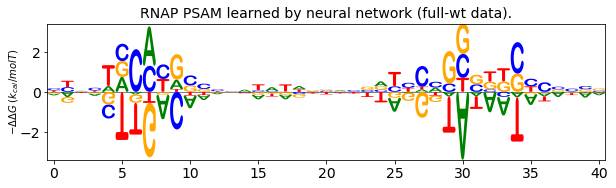

In [45]:
rnap_logo_df = pd.DataFrame(rnap_weights,columns=['A','C','G','T'])
rnap_df.columns = ['A','C','G','T']
logomaker.Logo(-rnap_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.tick_params(labelsize=14)
plt.title('RNAP PSAM Reported in Kinney et al. 2010',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{cal}/mol T$)", labelpad=-1)
logomaker.Logo(-rnap_logo_df,center_values=True, font_name='Arial Rounded MT Bold')
plt.tick_params(labelsize=14)
plt.title('RNAP PSAM learned by neural network (full-wt data).',fontsize=14)
plt.ylabel("$-\Delta \Delta G$ ($k_{cal}/mol T$)", labelpad=-1)
plt.tick_params(labelsize=14)

In [46]:
model.layers[6].get_weights()

[array([ 0.8012073, -1.9915426, -1.7239264,  1.1090472], dtype=float32),
 array([[0., 1., 0., 1.],
        [0., 0., 1., 1.]], dtype=float32)]

In [47]:
model.layers[7].get_weights()

[array([[0.      ],
        [0.      ],
        [3.355523],
        [3.551023]], dtype=float32)]

### MI estimation

In [48]:
tau_layer_model = Model(inputs=model.input,outputs=model.layers[7].output)
tau_output = tau_layer_model.predict(test_input_sequences_tensor)


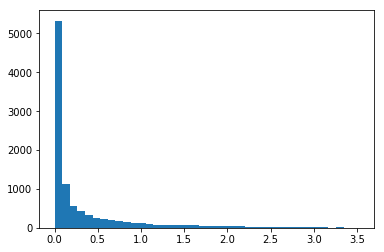

In [49]:
plt.hist(tau_output,bins=40)
plt.show()

In [50]:
# estimate probability density at each of the output bins using deft. 
import suftware

In [51]:
softmax_bin_layer_model = Model(inputs=model.input,outputs=model.layers[9].output)
softmax_bin_out = softmax_bin_layer_model.predict(test_input_sequences_tensor)


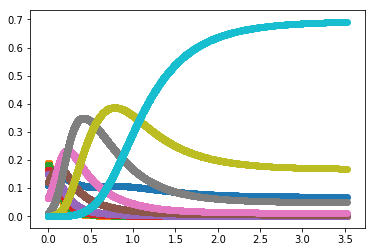

In [52]:
for _ in range(10):
    plt.scatter(tau_output,softmax_bin_out[:,_])
plt.show()

In [53]:
# y_test -> bin number
# tau_output -> tau
# find p(tau|bin)

total_bins = 10

function_dict = {}

tau_given_bin = {}
for b in range(total_bins):
    temp_tau_given_bin_n = []
    for _ in range(len(y_test)):
        if(y_test[_]==b):
            temp_tau_given_bin_n.append(tau_output[_])
    tau_given_bin[str(b)]= np.array(temp_tau_given_bin_n).flatten()  
    Q_star = suftware.DensityEstimator(np.array(temp_tau_given_bin_n).flatten(),alpha=3).density_func
    print(b)
    function_dict[str(b)] = Q_star

0
1
2
3
4
5
6
7
8
9


In [54]:
tau_given_bin['6']

array([1.10786324e-02, 3.03593248e-01, 1.30084753e-01, 9.80773289e-03,
       6.28726259e-02, 1.01838708e+00, 1.55891359e-01, 5.86216986e-01,
       1.12024300e-01, 8.32838379e-03, 4.78051960e-01, 1.79030642e-01,
       1.53274789e-01, 2.20442504e-01, 4.44678962e-01, 4.76830244e-01,
       3.02444282e-03, 2.52763271e-01, 1.52686447e-01, 2.09925652e-01,
       3.17192435e-01, 3.62449199e-01, 1.19257554e-01, 1.27754435e-01,
       1.63517833e-01, 2.83525944e-01, 7.49802589e-03, 2.23000109e-01,
       6.79796562e-04, 3.15493286e-01, 1.58906600e-03, 3.21767837e-01,
       1.63140103e-01, 1.94349915e-01, 2.50133991e-01, 1.09156549e-01,
       4.49528135e-02, 3.56448233e-01, 2.26798374e-02, 1.50101125e-01,
       4.83524054e-02, 7.32999593e-02, 9.68539901e-03, 2.27819964e-01,
       3.64885449e-01, 1.37968615e-01, 3.42034876e-01, 2.07302094e-01,
       1.48190424e-01, 2.77557913e-02, 1.32253483e-01, 4.35061939e-02,
       2.79465497e-01, 2.22385526e-01, 2.18557283e-01, 2.29840994e-01,
      

In [55]:
# rename function dict to Qstar dict, 
# comment out code below
# compute mutual information on full data?

In [56]:
#suftware.DensityEstimator(np.log(tau_given_bin['6']))
num_gridpoints = 1000
gridpoints = np.linspace(min(tau_output),max(tau_output),num_gridpoints)
h = gridpoints[1] - gridpoints[0]

SMALL = 1E-10
bins = 10

def p_tau_given_bin(x,b):
    key = '%d'%b
    return function_dict[key](x) + SMALL

def p_tau(x):
    tmp = np.zeros(len(x))
    for f in function_dict.values():
        tmp += f(x)
    tmp /= len(function_dict) + SMALL
    return tmp
 
mutual_information = sum([sum(h * p_tau_given_bin(gridpoints,b) * np.log2(p_tau_given_bin(gridpoints,b) / p_tau(gridpoints))) 
                          for b in range(0,bins)]) / bins

print(mutual_information)

0.8622787701902237


/Users/tareen/miniconda3/lib/python3.6/site-packages/suftware/src/DensityEvaluator.py:91: RuntimeWarning: overflow encountered in exp
  values = np.exp(-self.field_func(xs)) / self.Z


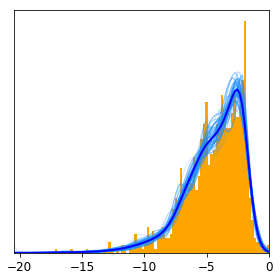

In [57]:
density = suftware.DensityEstimator(np.log(tau_given_bin['4']))
density.plot()

In [58]:
# 15156 0.5425835651212284
print(len(y_test), mutual_information)

10104 0.8622787701902237


Text(0.06,0.5,'Bin Number')

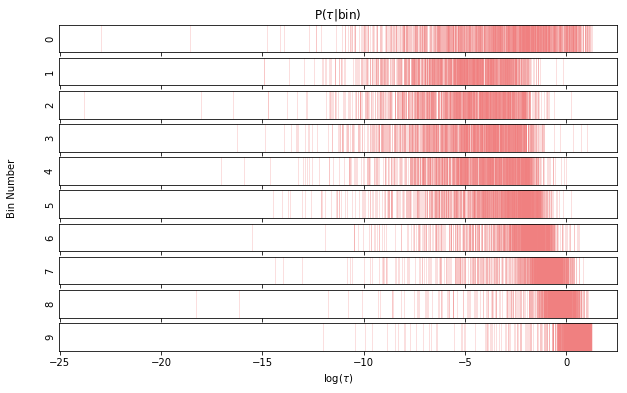

In [59]:
fig, ax = plt.subplots(nrows=bins,sharex=True, ncols=1,figsize=(10,6))   
ax[0].set_title(r'P($\tau$|bin)')

for bin_index in range(bins):

    for xc in np.log(tau_given_bin[str(bin_index)]):
        
        ax[bin_index].axvline(x=xc,alpha=0.25,linewidth=1,color='lightcoral')
        
    ax[bin_index].set_ylabel(str(bin_index))
    ax[bin_index].set_yticks([])
    
ax[bin_index].set_xlabel(r'$\log(\tau)$')    
fig.text(0.06, 0.5, 'Bin Number', ha='center', va='center', rotation='vertical')    
# plt.savefig('bin_vs_log_tau.pdf')

In [60]:
# for temp_index in range(10):

#     np.savetxt(str(temp_index)+'.txt',np.log(tau_given_bin[str(temp_index)]))